In [1]:
import os
if not os.path.exists('dataset1'):
    !wget -q https://www.dropbox.com/s/0pigmmmynbf9xwq/dataset1.zip
    !unzip -q dataset1.zip
    !rm dataset1.zip
    !pip install -q torch_snippets pytorch_model_summary

from torch_snippets import *
from torchvision import transforms
from sklearn.model_selection import train_test_split
device = 'cuda' if torch.cuda.is_available() else 'cpu'

     |████████████████████████████████| 49 kB 2.9 MB/s 
     |████████████████████████████████| 948 kB 12.9 MB/s 
     |████████████████████████████████| 78 kB 2.7 MB/s 
     |████████████████████████████████| 11.1 MB 41.7 MB/s 
     |████████████████████████████████| 58 kB 5.6 MB/s 
     |████████████████████████████████| 59 kB 7.0 MB/s 
     |████████████████████████████████| 231 kB 42.2 MB/s 
     |████████████████████████████████| 51 kB 5.9 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.4.0 which is incompatible.


In [2]:
from glob import glob

class Segmen_DS(Dataset):
  def __init__(self,folder1,folder2):
    self.image = glob(folder1+'/*.png')
    self.annot = glob(folder2+'/*.png')
    self.normalize = transforms.Compose([
                                         transforms.ToTensor(),
                                         transforms.Normalize(mean=[0.485,0.456,0.406],
                                                              std=[0.229,0.224,0.225])
    ])

  def __len__(self): return len(self.image)
  def __getitem__(self,ix):
    fpath = self.image[ix]
    image = read(fpath,1)
    image = cv2.resize(image,(224,224))

    mask = self.annot[ix]
    mask = read(mask)
    mask = cv2.resize(mask,(224,224))

    return image, mask

  def choose(self): return self[randint(len(self))]
  def collate_fn(self,batch):
    ims, masks = list(zip(*batch))
    ims = torch.cat([self.normalize(im.copy()/225)[None] for im in ims]).float().to(device)
    ce_masks = torch.cat([torch.Tensor(mask[None]) for mask in masks]).long().to(device)

    return ims, ce_masks

In [3]:
trn_dir = '/content/dataset1/images_prepped_train'
trn_annot = '/content/dataset1/annotations_prepped_train'
trn_ds = Segmen_DS(trn_dir,trn_annot)

val_dir = '/content/dataset1/images_prepped_train'
val_annot = '/content/dataset1/annotations_prepped_train'
val_ds = Segmen_DS(val_dir,val_annot)

trn_dl = DataLoader(trn_ds,batch_size=4,shuffle=True,collate_fn=trn_ds.collate_fn)
val_dl = DataLoader(val_ds,batch_size=1,shuffle=True,collate_fn=val_ds.collate_fn)

In [4]:
def conv(ic,oc): # ic=number of in-channels, oc=number of out-channels
  return nn.Sequential(
      nn.Conv2d(ic,oc,kernel_size=3,stride=1,padding=1),
      nn.BatchNorm2d(oc),
      nn.ReLU(inplace=True)
  )

def up_conv(ic,oc):
  return nn.Sequential(
      nn.ConvTranspose2d(ic,oc,kernel_size=2,stride=2),
      nn.ReLU(inplace=True)
  )

In [5]:
from torchvision.models import vgg16_bn
model = vgg16_bn(pretrained=True)
model.features

Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU(inplace=True)
  (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (9): ReLU(inplace=True)
  (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (12): ReLU(inplace=True)
  (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (14): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 

In [6]:
class Unet(nn.Module):
    def __init__(self, oc=12):
        super().__init__()

        self.encoder = vgg16_bn(pretrained=True).features
        self.block1 = nn.Sequential(*self.encoder[:6])
        self.block2 = nn.Sequential(*self.encoder[6:13])
        self.block3 = nn.Sequential(*self.encoder[13:20])
        self.block4 = nn.Sequential(*self.encoder[20:27])
        self.block5 = nn.Sequential(*self.encoder[27:34])

        self.bottleneck = nn.Sequential(*self.encoder[34:])
        self.conv_bottleneck = conv(512, 1024)

        self.up_conv1 = up_conv(1024, 512)
        self.conv1 = conv(512 + 512, 512)
        self.up_conv2 = up_conv(512, 256)
        self.conv2 = conv(256 + 512, 256)
        self.up_conv3 = up_conv(256, 128)
        self.conv3 = conv(128 + 256, 128)
        self.up_conv4 = up_conv(128, 64)
        self.conv4 = conv(64 + 128, 64)
        self.up_conv5 = up_conv(64, 32)
        self.conv5 = conv(32 + 64, 32)
        self.conv6 = nn.Conv2d(32, oc, kernel_size=1)
    def forward(self, x):
        block1 = self.block1(x)
        block2 = self.block2(block1)
        block3 = self.block3(block2)
        block4 = self.block4(block3)
        block5 = self.block5(block4)

        bottleneck = self.bottleneck(block5)
        x = self.conv_bottleneck(bottleneck)

        x = self.up_conv1(x)
        x = torch.cat([x, block5], dim=1)
        x = self.conv1(x)

        x = self.up_conv2(x)
        x = torch.cat([x, block4], dim=1)
        x = self.conv2(x)

        x = self.up_conv3(x)
        x = torch.cat([x, block3], dim=1)
        x = self.conv3(x)

        x = self.up_conv4(x)
        x = torch.cat([x, block2], dim=1)
        x = self.conv4(x)

        x = self.up_conv5(x)
        x = torch.cat([x, block1], dim=1)
        x = self.conv5(x)

        x = self.conv6(x)

        return x

In [9]:
loss_fn = nn.CrossEntropyLoss()
def Unet_Loss(preds,targets):
  loss = loss_fn(preds,targets)
  acc = (torch.max(preds,1)[1]==targets).float().mean()
  return loss, acc

criterion = Unet_Loss

def train_batch(data,model,optimizer,criterion):
  model.train()
  optimizer.zero_grad()
  ims, masks = data
  _masks = model(ims)
  loss, acc = criterion(_masks,masks)
  loss.backward()
  optimizer.step()
  return loss.item(), acc.item()

@torch.no_grad()
def validate_batch(data,model,criterion):
  model.eval()
  ims, masks = data
  _masks = model(ims)
  loss, acc = criterion(_masks,masks)
  return loss.item(), acc.item()

model = Unet().to(device)
optimizer = torch.optim.Adam(model.parameters(),lr=1e-3)
n_epochs = 10

In [10]:
log = Report(n_epochs)
for epoch in range(n_epochs):
  N = len(trn_dl)
  for ix, data in enumerate(iter(trn_dl)):
    loss, acc = train_batch(data,model,optimizer,criterion)
    log.record(epoch+(ix+1)/N,trn_loss=loss,trn_acc=acc,end='\r')

  N = len(val_dl) 
  for ix, data in enumerate(iter(val_dl)):
    loss, acc = validate_batch(data,model,criterion)
    log.record(epoch+(ix+1)/N,val_loss=loss,val_acc=acc,end='\r')
  
  log.report_avgs(epoch+1)


EPOCH: 1.000	trn_loss: 1.145	trn_acc: 0.749	val_loss: 0.750	val_acc: 0.820	(20.53s - 184.81s remaining)
EPOCH: 2.000	trn_loss: 0.683	trn_acc: 0.827	val_loss: 0.592	val_acc: 0.842	(41.04s - 164.14s remaining)
EPOCH: 3.000	trn_loss: 0.565	trn_acc: 0.848	val_loss: 0.620	val_acc: 0.833	(61.52s - 143.55s remaining)
EPOCH: 4.000	trn_loss: 0.557	trn_acc: 0.846	val_loss: 0.519	val_acc: 0.858	(87.86s - 131.79s remaining)
EPOCH: 5.000	trn_loss: 0.496	trn_acc: 0.863	val_loss: 0.474	val_acc: 0.871	(113.35s - 113.35s remaining)
EPOCH: 6.000	trn_loss: 0.452	trn_acc: 0.875	val_loss: 0.396	val_acc: 0.889	(135.96s - 90.64s remaining)
EPOCH: 7.000	trn_loss: 0.419	trn_acc: 0.882	val_loss: 0.423	val_acc: 0.881	(158.70s - 68.01s remaining)
EPOCH: 8.000	trn_loss: 0.388	trn_acc: 0.889	val_loss: 0.368	val_acc: 0.896	(187.25s - 46.81s remaining)
EPOCH: 9.000	trn_loss: 0.371	trn_acc: 0.894	val_loss: 0.389	val_acc: 0.889	(209.61s - 23.29s remaining)
EPOCH: 10.000	trn_loss: 0.377	trn_acc: 0.891	val_loss: 0.385	va

100%|██████████| 111/111 [00:00<00:00, 722.01it/s]


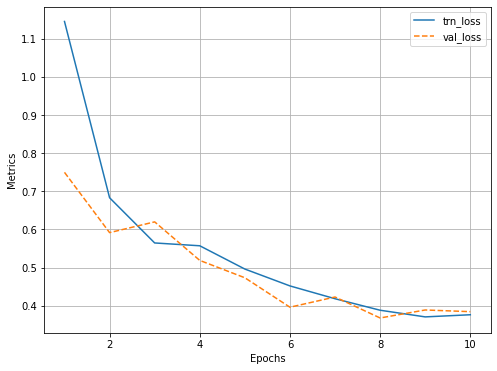

In [11]:
log.plot_epochs(['trn_loss','val_loss'])

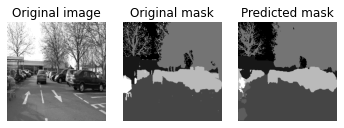

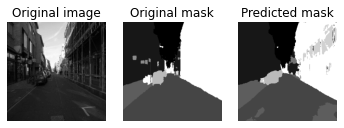

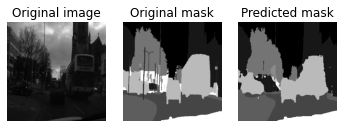

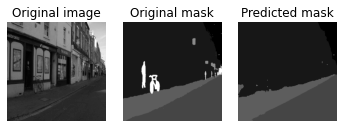

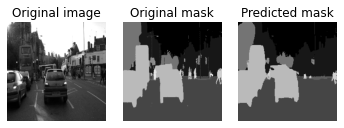

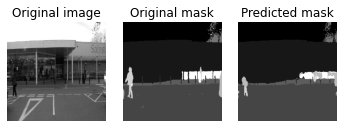

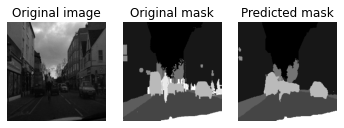

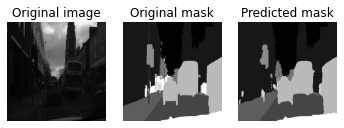

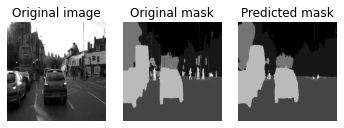

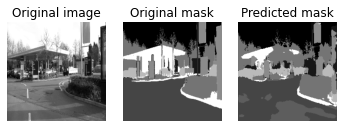

In [22]:
for _ in range(10):
  img, mask = next(iter(val_dl))
  _mask = model(img)
  _mask = torch.max(_mask,1)[1]
  subplots([img[0].permute(1,2,0).detach().cpu()[:,:,0], mask.permute(1,2,0).detach().cpu()[:,:,0],_mask.permute(1,2,0).detach().cpu()[:,:,0]],\
          nc=3, titles=['Original image','Original mask','Predicted mask'])

In [23]:
img.shape

torch.Size([1, 3, 224, 224])